## 07. PyTorch Experiment Tracking

### Milestone Project 1: FoodVision Mini Experiment Tracking

#### What is experiment tracking?

=> helps you figure out what works and what doesn't.

> If you are only running a handful of models, it might be okay just to track their results in print outs and a few dictionaries.
>
> However, as the number of exoeriments you runs starts to increase, this naive way of tracking could get out of hand.


#### Diffrent ways to track machine learning experiments
- Python dictionaries, CSV fiels, print outs
- TensorBoard
- Weights & Bias Experiment Tracking
- MlFlow

### 0. Set up

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0.dev20230709
0.16.0.dev20230709


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

'mps'

### 1. Get Data

In [3]:
# using pizza, steak, sushi images
import os
import zipfile
from pathlib import Path
import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists, skipping re-download.")
else:
    print(f"Did not find {image_path}, downloading it...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists, skipping re-download.


### 2. Create Datasets and Dataloaders

#### 2.1 Create with manual transforms

In [4]:
train_dir = image_path / "train"
test_dir = image_path /"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [5]:
# Setup ImageNet normalization levels
# https://pytorch.org/vision/0.12/models.html 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

from torchvision import transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [6]:
from go_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x10613a0e0>,
 ['pizza', 'steak', 'sushi'])

#### 2.2 Create with auto transforms

In [7]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these weights available in torchvision.models v0.13+)
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available

# Get transforms from weights (these are the transforms used to train a particular or obtain a particular set of weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")


Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [8]:
from go_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x105ffefe0>,
 ['pizza', 'steak', 'sushi'])

### 3. Get pre-trained model, freeze the base layers and change the classifier head

In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights

# Setup the model with the pretrained weights and send it to the target device
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model = torchvision.models.efficientnet_b0()
model.load_state_dict(torch.load("models/efficientnet_b0_rwightman-3dd342df.pth"))
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:

# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [11]:
from torch import nn
torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [12]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 4. Train a single model and track results

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##### To track experiments -> use `TensorBoard` - https://www.tensorflow.org/tensorboard/

##### To interact with TensorBoard-> use `PyTorch's SummaryWriter`

https://pytorch.org/docs/stable/tensorboard.html

https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter


In [14]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [15]:
from go_modular.engine import train_step, test_step

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.
    Calculates, prints and stores evaluation metrics throughout.
    """

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        print(f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        """ Experiment Tracking """
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224))
    
    # close the writer
    writer.close()

    return results

In [16]:
torch.manual_seed(42)

train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs= 5, device="cpu")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8706 | test_acc: 0.7216
Epoch: 2 | train_loss: 0.8990 | train_acc: 0.6875 | test_loss: 0.7912 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7840 | train_acc: 0.7070 | test_loss: 0.6659 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.6512 | train_acc: 0.8867 | test_loss: 0.6308 | test_acc: 0.8750
Epoch: 5 | train_loss: 0.7059 | train_acc: 0.7227 | test_loss: 0.6211 | test_acc: 0.8343


{'train_loss': [1.0882934033870697,
  0.8990411832928658,
  0.7840343192219734,
  0.6511537060141563,
  0.7058600559830666],
 'train_acc': [0.41796875, 0.6875, 0.70703125, 0.88671875, 0.72265625],
 'test_loss': [0.8705632289250692,
  0.7912198106447855,
  0.6659036676088969,
  0.6308210492134094,
  0.6210600733757019],
 'test_acc': [0.7215909090909092,
  0.7840909090909092,
  0.90625,
  0.875,
  0.8342803030303031]}

### 5. View model's results with TensorBoard

https://www.learnpytorch.io/07_pytorch_experiment_tracking/#5-view-our-models-results-in-tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs --host localhost --port 8888

### 6. Create a helper function to build `SummaryWriter()` instances

=> The `SummaryWriter()` class logs various information to a directory specified by the `log_dir` parameter.

=> How about we make a helper function to create a custom directory per experiment?
> each experiment gets its own logs directory.  -> one experiment = one folder

##### => track things like:
> (1) **Experiment date/timestamp**
>
> (2) **Experiment name**
>
> (3) **Model name** -> what model was used?
>
> (4) **Extra** -> anything else that should be tracked?

Create a helper function called `create_writer()` that produces a `SummaryWriter()` instance tracking to a custom `log_dir`.

=> Ideally, `log_dir` => something like: `runs/YYYY-MM-DD/experiment_name/model_name/extra`.


In [16]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """ Create a SummaryWriter() instance saving to a specific log_dir. """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format
    
    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [17]:
example_writer = create_writer(experiment_name="data_10_precent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter, saving to: runs/2023-08-03/data_10_precent/effnetb0/5_epochs...


#### 6.1 Update the `train()` function to include a `writer` parameter

In [18]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from go_modular.engine import train_step, test_step


def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        """ Experiment Tracking """
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)
            writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224))
    
            # close the writer
            writer.close()

    return results

### 7. Set up s series of modelling experiments

=> What if we could run multiple experiments and then inspect the results all together?

#### 7.1 What kind of experiments should you run?

=> Every hyperparameter stands as a starting point for a different experiment:
- Change the number of **epochs**
- Change the number of **layers/hidden units**
- Change the amount of **data**
- Change the **learning rate**
- Try different kinds of **data augmentation**
- Choose a different **model architecture**

#### 7.2 What experiments are we going ti run?

=> **Goal:** improve the model powering FoodVision Mini without it getting too big.

=> try a combination of:
> (1) a differemt amout of data (10% of Pizza, Steak, Sushi *VS.* 20%)
>
> (2) a different model (torchvision.models.`efficientnet_b0` *VS.* torchvision.models.`efficientnet_b2`)
>
> (3) a different training time (5 epochs *VS.* 10 epochs)
>
> => total: 8 experiments

#### 7.3 Download different datasets

- A training set with **10% of the data** of Food101 pizza, steak, sushi images
- A training set with **20% of the data** of Food101 pizza, steak, sushi images.

In [19]:
# using pizza, steak, sushi images
import os
import zipfile
from pathlib import Path
import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists, skipping re-download.")
else:
    print(f"Did not find {image_path}, downloading it...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi_20_percent.zip")

data/pizza_steak_sushi_20_percent directory exists, skipping re-download.


#### 7.4 Transform Datasets and Create Dataloaders

In [20]:
# Setup training directory paths
data_10_percent_path = data_path / "pizza_steak_sushi"
data_20_percent_path = data_path / "pizza_steak_sushi_20_percent"

train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"
# Setup the test directory -> use 10_percent test dataset
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [21]:
# create dataloaders
from torchvision import transforms

# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into a pipleine
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

BATCH_SIZE = 32
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)
print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

- (1) Creates a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB0).
- (2) Creates a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB2).

In [22]:
import torchvision

# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" = best available
effnetb2 = torchvision.models.efficientnet_b2()
effnetb2.load_state_dict(torch.load("models/efficientnet_b2_rwightman-bcdf34b7.pth"))
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [23]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [24]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # Get the weights and setup a model
    model = torchvision.models.efficientnet_b0()    
    model.load_state_dict(torch.load("models/efficientnet_b0_rwightman-3dd342df.pth"))
    
    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Change the classifier head
    torch.manual_seed(42)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    )

    # Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model...")
    return model

In [25]:
# Create an EffNetB2 feature extractor
def create_effnetb2():
    # Get the weights and setup a model
    model = torchvision.models.efficientnet_b2()
    model.load_state_dict(torch.load("models/efficientnet_b2_rwightman-bcdf34b7.pth"))

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change the classifier head
    torch.manual_seed(42)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    )

    # Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model...")
    return model

In [26]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [27]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[INFO] Created new effnetb2 model...
[INFO] Created new effnetb0 model...


In [28]:
# Check out EffNetB2 feature extractor
summary(model=created_model_test_effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [29]:
# Check out EffNetB0 feature extractor model
summary(model=created_model_test_effnetb0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

#### 7.6 Create experiments and set up training code

In [30]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"] 

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [31]:
%%time
from go_modular.utils import save_model

torch.manual_seed(42)
# Keep track of experiment numbers
experiment_number = 0

# loop trough each dataloader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # loop through the epochs
    for epochs in num_epochs:
        # loop through each model name and create a new model instance
        for model_name in models:
            # print out info
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            
            # create a new loss and oprimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # train target model with target dataloader and track experiments
            # Note: using train() rather than engine.train()
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device="cpu",
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # save the model to file so can impoer it later if needed
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 0
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter, saving to: runs/2023-08-03/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.8974 | test_acc: 0.5265
Epoch: 2 | train_loss: 0.8871 | train_acc: 0.6523 | test_loss: 0.7414 | test_acc: 0.7093
Epoch: 3 | train_loss: 0.8393 | train_acc: 0.6250 | test_loss: 0.7348 | test_acc: 0.7225
Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7539 | test_loss: 0.6311 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6088 | train_acc: 0.9180 | test_loss: 0.6008 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 0
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter, saving to: runs/2023-08-03/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9350 | test_acc: 0.7320
Epoch: 2 | train_loss: 0.8706 | train_acc: 0.7969 | test_loss: 0.8610 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.8527 | train_acc: 0.6641 | test_loss: 0.7596 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.6644 | train_acc: 0.9180 | test_loss: 0.7253 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.6806 | train_acc: 0.7422 | test_loss: 0.6465 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 0
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter, saving to: runs/2023-08-03/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.8974 | test_acc: 0.5265
Epoch: 2 | train_loss: 0.8871 | train_acc: 0.6523 | test_loss: 0.7414 | test_acc: 0.7093
Epoch: 3 | train_loss: 0.8393 | train_acc: 0.6250 | test_loss: 0.7348 | test_acc: 0.7225
Epoch: 4 | train_loss: 0.7101 | train_acc: 0.7539 | test_loss: 0.6311 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6088 | train_acc: 0.9180 | test_loss: 0.6008 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5628 | train_acc: 0.9023 | test_loss: 0.5336 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.6252 | train_acc: 0.7539 | test_loss: 0.5931 | test_acc: 0.8153
Epoch: 8 | train_loss: 0.5034 | train_acc: 0.8164 | test_loss: 0.4630 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.4490 | train_acc: 0.9258 | test_loss: 0.4264 | test_acc: 0.9271
Epoch: 10 | train_loss: 0.5786 | train_acc: 0.7695 | test_loss: 0.4400 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9350 | test_acc: 0.7320
Epoch: 2 | train_loss: 0.8706 | train_acc: 0.7969 | test_loss: 0.8610 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.8527 | train_acc: 0.6641 | test_loss: 0.7596 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.6644 | train_acc: 0.9180 | test_loss: 0.7253 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.6806 | train_acc: 0.7422 | test_loss: 0.6465 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5808 | train_acc: 0.9062 | test_loss: 0.6328 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.5418 | train_acc: 0.9375 | test_loss: 0.5782 | test_acc: 0.9062
Epoch: 8 | train_loss: 0.4960 | train_acc: 0.9375 | test_loss: 0.5789 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5402 | train_acc: 0.7891 | test_loss: 0.5425 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.4854 | train_acc: 0.8125 | test_loss: 0.5048 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6758 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.6999 | train_acc: 0.8250 | test_loss: 0.5420 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.5369 | train_acc: 0.8854 | test_loss: 0.4402 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.4602 | train_acc: 0.8917 | test_loss: 0.3831 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.4646 | train_acc: 0.8208 | test_loss: 0.3643 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 0
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter, saving to: runs/2023-08-03/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7774 | test_acc: 0.8248
Epoch: 2 | train_loss: 0.7282 | train_acc: 0.7958 | test_loss: 0.6650 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5830 | train_acc: 0.8958 | test_loss: 0.5210 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.5373 | train_acc: 0.8500 | test_loss: 0.4956 | test_acc: 0.9167
Epoch: 5 | train_loss: 0.4321 | train_acc: 0.9062 | test_loss: 0.4655 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 0
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter, saving to: runs/2023-08-03/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6758 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.6999 | train_acc: 0.8250 | test_loss: 0.5420 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.5369 | train_acc: 0.8854 | test_loss: 0.4402 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.4602 | train_acc: 0.8917 | test_loss: 0.3831 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.4646 | train_acc: 0.8208 | test_loss: 0.3643 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.4371 | train_acc: 0.8625 | test_loss: 0.3798 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3709 | train_acc: 0.8667 | test_loss: 0.3657 | test_acc: 0.9186
Epoch: 8 | train_loss: 0.3608 | train_acc: 0.8833 | test_loss: 0.2756 | test_acc: 0.9583
Epoch: 9 | train_loss: 0.2940 | train_acc: 0.9208 | test_loss: 0.3034 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.2782 | train_acc: 0.9333 | test_loss: 0.2717 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7774 | test_acc: 0.8248
Epoch: 2 | train_loss: 0.7282 | train_acc: 0.7958 | test_loss: 0.6650 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5830 | train_acc: 0.8958 | test_loss: 0.5210 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.5373 | train_acc: 0.8500 | test_loss: 0.4956 | test_acc: 0.9167
Epoch: 5 | train_loss: 0.4321 | train_acc: 0.9062 | test_loss: 0.4655 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4076 | train_acc: 0.9250 | test_loss: 0.4153 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.3858 | train_acc: 0.9208 | test_loss: 0.4100 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3653 | train_acc: 0.9021 | test_loss: 0.3694 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3070 | train_acc: 0.9375 | test_loss: 0.3476 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.3373 | train_acc: 0.9125 | test_loss: 0.3352 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

### 8. View epeiments in Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs --host localhost --port 8888

##### The best performing model:
- Model: EffNetB2
- Dataset: 20% pizza, steak, sushi
- Epochs: 10

In [ ]:
# Upload the results to TensorBoard.dev ?
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model result" \
#     --description "Comparing results of different model size, training data amount and training time."
#     --one_shot

### 9. Load in the best model and make predictions with it

=> best model filepath: `models/07_effnetb2_data_20_percent_10_epochs.pth`

In [36]:
# Set up model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2
best_model = create_effnetb2()

# Load state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [37]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [40]:
# %%writefile go_modular/predictions.py
""" Uses a trained model to make predictions on images """

import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int],
                        transform: torchvision.transforms,
                        device: torch.device):
    img = Image.open(image_path)

    # create a transform is one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transform.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
    
    # make sure the model is on the target device
    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_img_pred = model(transformed_image.to(device))
    
    target_img_pred_prob = torch.softmax(target_img_pred, dim=1)
    target_img_pred_label = torch.argmax(target_img_pred_prob, dim=1)

    # plot the figure
    plt.figure()
    plt.imshow(img) 
    plt.title(f"Pred: {class_names[target_img_pred_label]} | Prob: {target_img_pred_prob.max():.3f}")
    plt.axis(False)

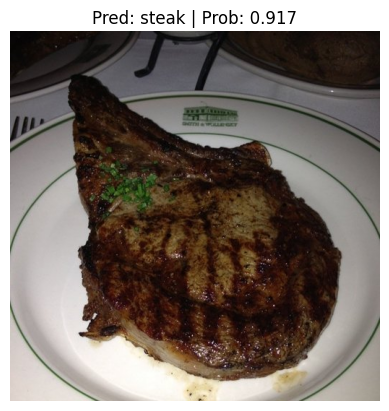

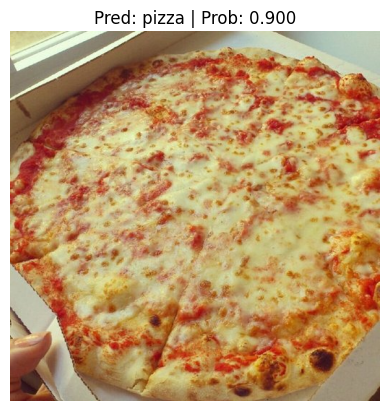

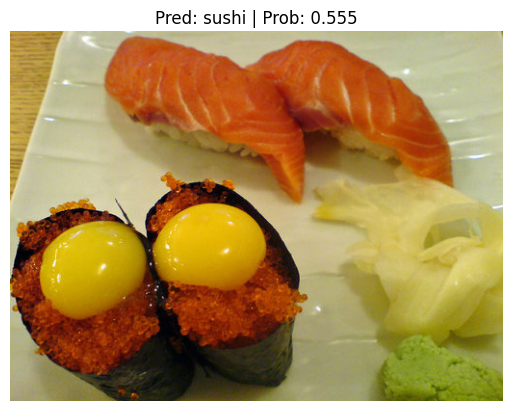

In [43]:
# from go_modular.predictions import pred_and_plot_image

# get 3 random images from 20% test set and make predictions
import random
import matplotlib.pyplot as plt

num_img_plot = 3
test_img_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
# randomly select k number of images
test_img_path_sample = random.sample(population=test_img_path_list,
                                     k=num_img_plot)

# make predictions
for img_path in test_img_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=img_path,
                        class_names=class_names,
                        image_size=(224, 224),
                        transform=simple_transform,
                        device="cpu")

#### 9.1 Predict on custom images with the best model

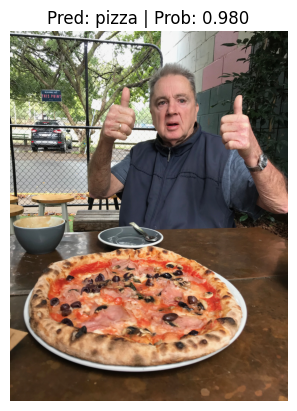

In [44]:
custom_image_path = data_path / "04-pizza-dad.jpeg"
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=simple_transform,
                    device="cpu")

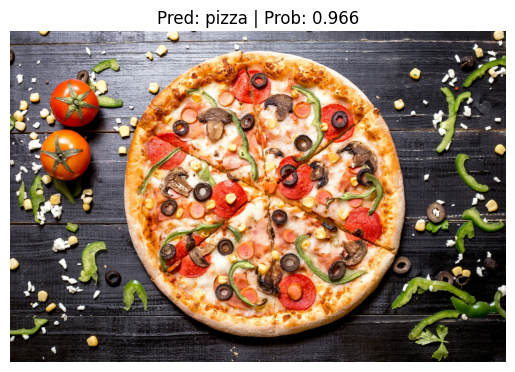

In [45]:
custom_image_path = data_path / "06_custom_pizza.jpg"
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=simple_transform,
                    device="cpu")

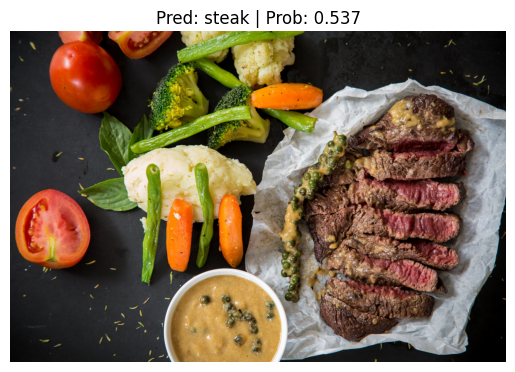

In [46]:
custom_image_path = data_path / "06_custom_steak.jpg"
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=simple_transform,
                    device="cpu")

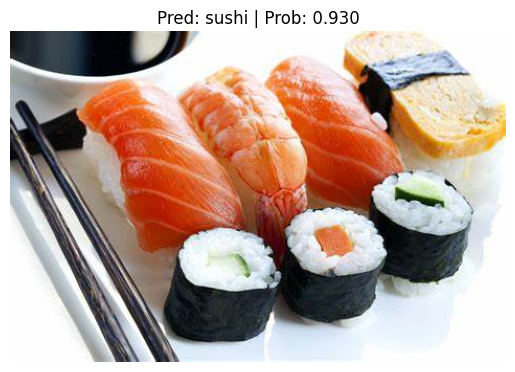

In [47]:
custom_image_path = data_path / "06_custom_sushi.jpeg"
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=simple_transform,
                    device="cpu")